# Financial News and Stock Market Prediction

## Task 1

### Importing the Necessary Libraries

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import datetime
import warnings

#### Load the dataset

In [77]:
# Load the dataset
data_path = "../data/raw_analyst_ratings.csv"
df = pd.read_csv(data_path)

### Inspect the Data
#### Check the structure of the data (columns, data types, missing values).

In [78]:
# Check the first few rows
df.head()


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [79]:

# Get summary information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
None


In [80]:
# Check for missing values
df.isnull().sum()

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

## Descriptive Statistics

### Analyze the length of headlines

In [81]:
# Calculate headline lengths
df['headline_length'] = df['headline'].apply(len)

# Descriptive statistics for headline lengths
print(df['headline_length'].describe())


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


In [82]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87


In [83]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

Number of duplicate rows: 0


### Publisher Frequency Analysis
Count the number of articles per publisher

In [84]:
# Number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print(publisher_counts)


publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


### Publication Date Trends
Convert the date column to datetime and analyze publication trends over time

In [85]:
df['date'] = pd.to_datetime(df['date'], format='ISO8601')

# Articles published per day
daily_articles = df.groupby(df['date'].dt.date).size()
print('Number of Articles per Day\n',daily_articles)


Number of Articles per Day
 date
2009-02-14      1
2009-04-27      2
2009-04-29      1
2009-05-22      1
2009-05-27      6
             ... 
2020-06-07     25
2020-06-08    765
2020-06-09    804
2020-06-10    806
2020-06-11    544
Length: 3955, dtype: int64


In [86]:
# Check the datatype of the date column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype                    
---  ------           --------------    -----                    
 0   Unnamed: 0       1407328 non-null  int64                    
 1   headline         1407328 non-null  object                   
 2   url              1407328 non-null  object                   
 3   publisher        1407328 non-null  object                   
 4   date             1407328 non-null  datetime64[ns, UTC-04:00]
 5   stock            1407328 non-null  object                   
 6   headline_length  1407328 non-null  int64                    
dtypes: datetime64[ns, UTC-04:00](1), int64(2), object(4)
memory usage: 75.2+ MB


## Text Analysis

### Sentiment Analysis
Perform sentiment analysis on the headlines using TextBlob

In [89]:
from textblob import TextBlob

# Function to get sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment'] = df['headline'].apply(get_sentiment)

# Basic sentiment statistics
print(df['sentiment'].describe())




count    1.407328e+06
mean     4.905657e-02
std      1.830652e-01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: sentiment, dtype: float64


In [97]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,sentiment
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,0.0
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,0.0
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,0.0
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,0.0
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,0.0


In [98]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a bag of words
vectorizer = CountVectorizer(max_features=10)
word_counts = vectorizer.fit_transform(df['headline'])
print(vectorizer.get_feature_names_out())


['eps' 'est' 'for' 'in' 'of' 'on' 'stocks' 'the' 'to' 'vs']


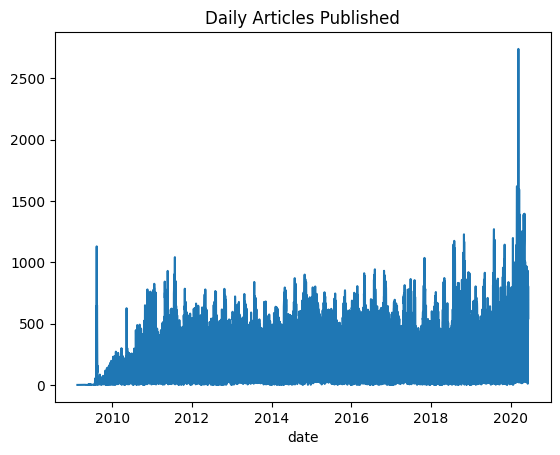

In [99]:
import matplotlib.pyplot as plt

daily_articles.plot(kind='line', title='Daily Articles Published')
plt.show()


In [100]:
# Extract time from date
df['time'] = df['date'].dt.time

# Analyze publication time patterns
time_distribution = df['time'].value_counts().sort_index()
print(time_distribution)


time
00:00:00    1351341
00:00:49          1
00:04:46          1
00:07:44          1
00:09:04          1
             ...   
23:48:39          1
23:50:09          1
23:51:34          1
23:53:33          1
23:56:55          1
Name: count, Length: 24394, dtype: int64


In [101]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,sentiment,time
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,0.0,10:30:54
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,0.0,10:45:20
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,0.0,04:30:07
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,0.0,12:45:06
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,0.0,11:38:59


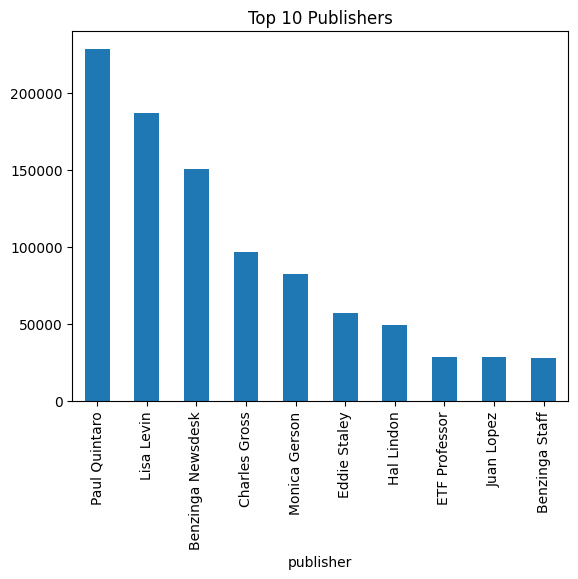

In [102]:
publisher_distribution = df['publisher'].value_counts().head(10)
publisher_distribution.plot(kind='bar', title='Top 10 Publishers')
plt.show()


In [104]:
df['domain'] = df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else x)
domain_counts = df['domain'].value_counts()
print(domain_counts)


domain
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
Mark Davis                1
janaviktoria              1
Kiana Danial              1
giovannimola              1
Jeremie Capron            1
Name: count, Length: 1024, dtype: int64


In [105]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,sentiment,time,domain
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,0.0,10:30:54,Benzinga Insights
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,0.0,10:45:20,Benzinga Insights
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,0.0,04:30:07,Lisa Levin
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,0.0,12:45:06,Lisa Levin
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,0.0,11:38:59,Vick Meyer
